In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from datetime import date
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.plotting import register_matplotlib_converters
from pmdarima.arima import ADFTest
register_matplotlib_converters()

In [16]:
df=pd.read_csv("TSLA.csv")
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


<function matplotlib.pyplot.show(close=None, block=None)>

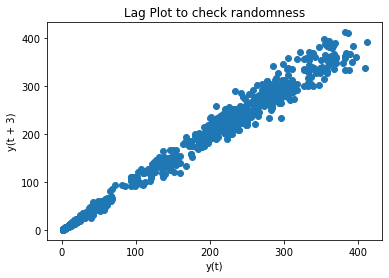

In [17]:
plt.figure()
lag_plot(df['Open'],lag=3)
plt.title('Lag Plot to check randomness')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

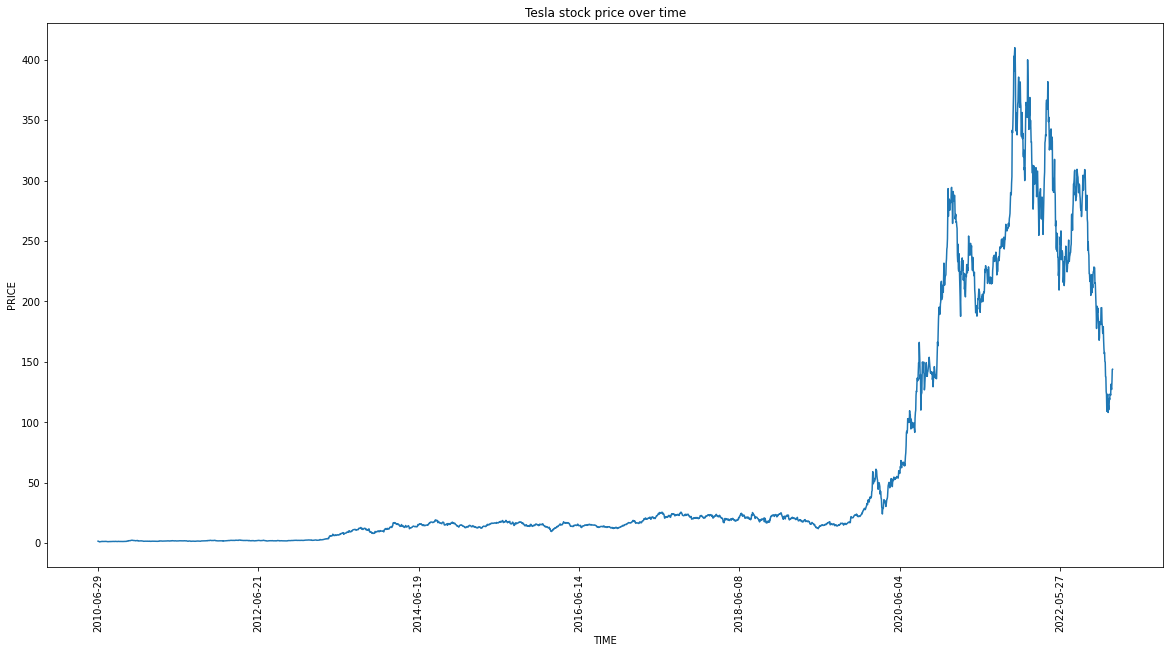

In [5]:
plt.figure(figsize=(20, 10))
plt.plot(df["Date"],df["Close"])
plt.xticks(np.arange(0,3500,500),df['Date'][0:3500:500],rotation='vertical')
plt.title("Tesla stock price over time")
plt.xlabel("TIME")
plt.ylabel("PRICE")
plt.show


In [6]:
adf_test=ADFTest(alpha = 0.05)
adf_test.should_diff(df['Close'])

(0.5751417221361467, True)

<Figure size 432x288 with 0 Axes>

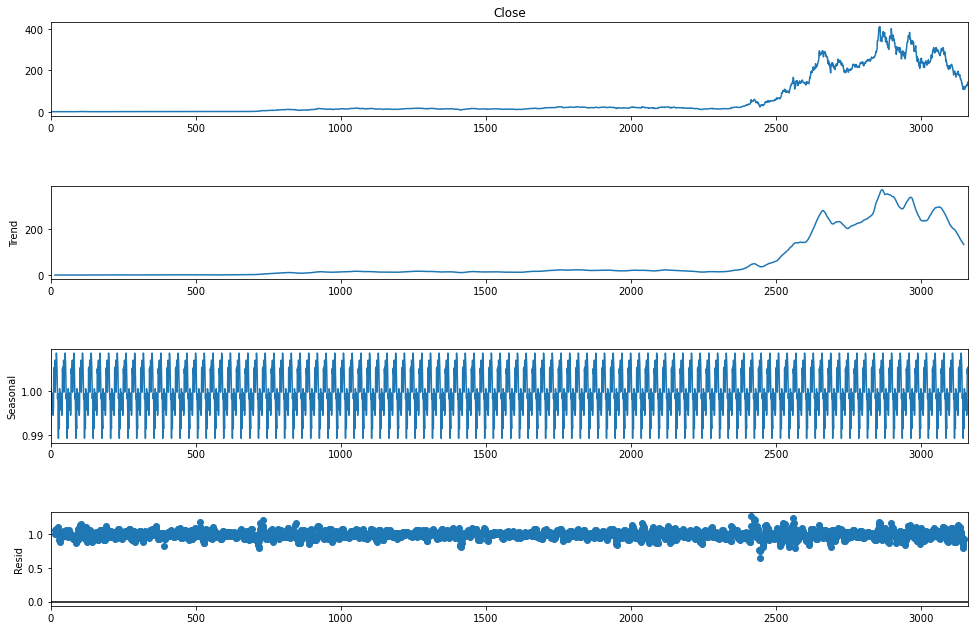

In [45]:
result = seasonal_decompose(df["Close"], 
                            model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

In [80]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < 0.05:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)


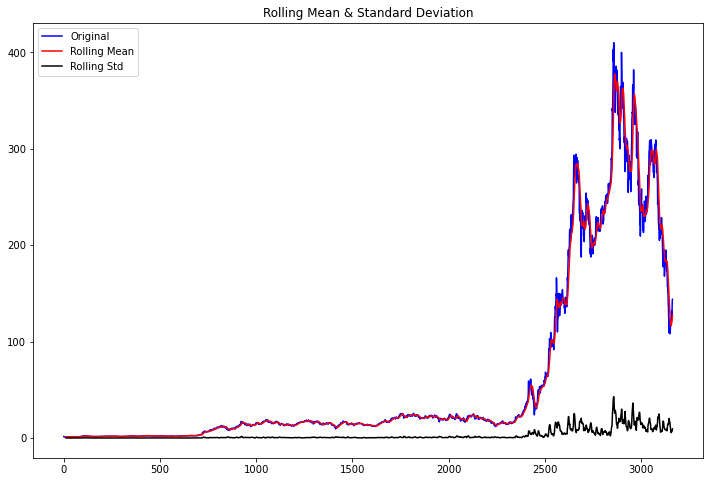

Results of Dickey-Fuller Test:
p-value = 0.6319. The series is likely non-stationary.
Test Statistic                   -1.293971
p-value                           0.631926
#Lags Used                       18.000000
Number of Observations Used    3146.000000
Critical Value (1%)              -3.432430
Critical Value (5%)              -2.862459
Critical Value (10%)             -2.567259
dtype: float64


In [76]:
test_stationarity(df['Close'])

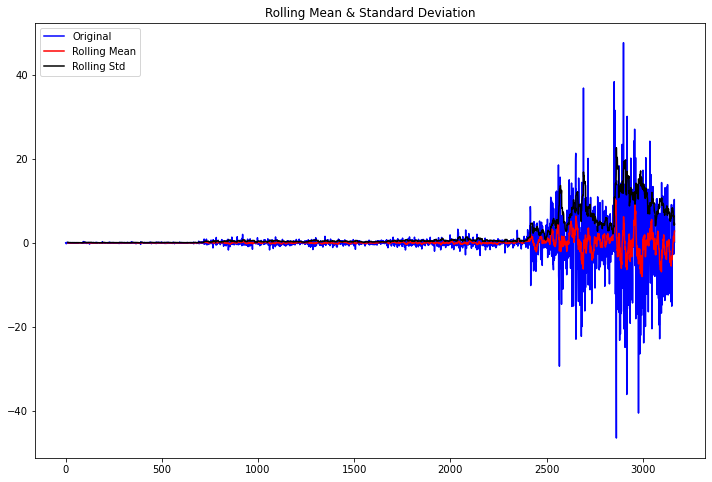

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.262611e+01
p-value                        1.540416e-23
#Lags Used                     1.700000e+01
Number of Observations Used    3.146000e+03
Critical Value (1%)           -3.432430e+00
Critical Value (5%)           -2.862459e+00
Critical Value (10%)          -2.567259e+00
dtype: float64


In [81]:
first_diff = df.Close - df.Close.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)


In [119]:
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))
print(model_fit.summary())

Testing Mean Squared Error is 66.13403523914238
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3164
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -9183.629
Date:                Mon, 30 Jan 2023   AIC                          18377.257
Time:                        04:11:07   BIC                          18407.554
Sample:                             0   HQIC                         18388.126
                               - 3164                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0380      0.008     -4.899      0.000      -0.053      -0.023
ar.L2          0.0154      0.007      2.335      0.020       0.002       0.028
ar.L

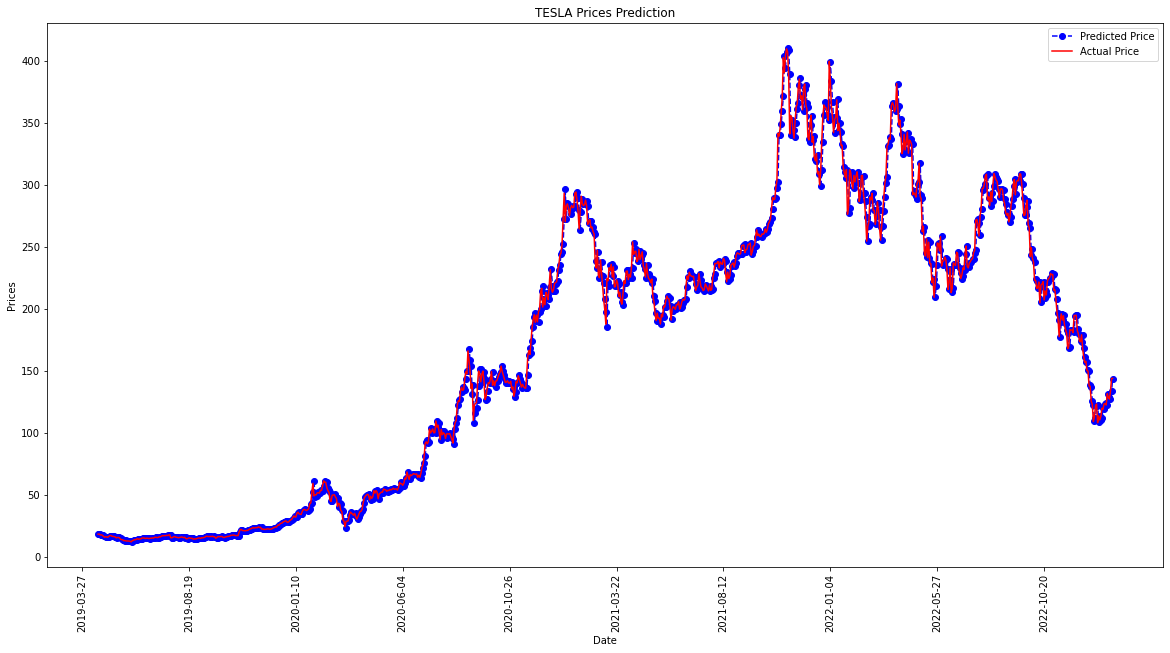

In [113]:
test_set_range = df[int(len(df)*0.7):].index
plt.figure(figsize=(20, 10))
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('TESLA Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.xticks(np.arange(2200,3146,100), df.Date[2200:3146:100],rotation='vertical')
plt.legend()
plt.show()

In [120]:
predictions = model_fit.predict()
print(predictions)

[  0.           1.59266579   1.58882256 ... 129.03710623 127.1404503
 133.52766091]


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

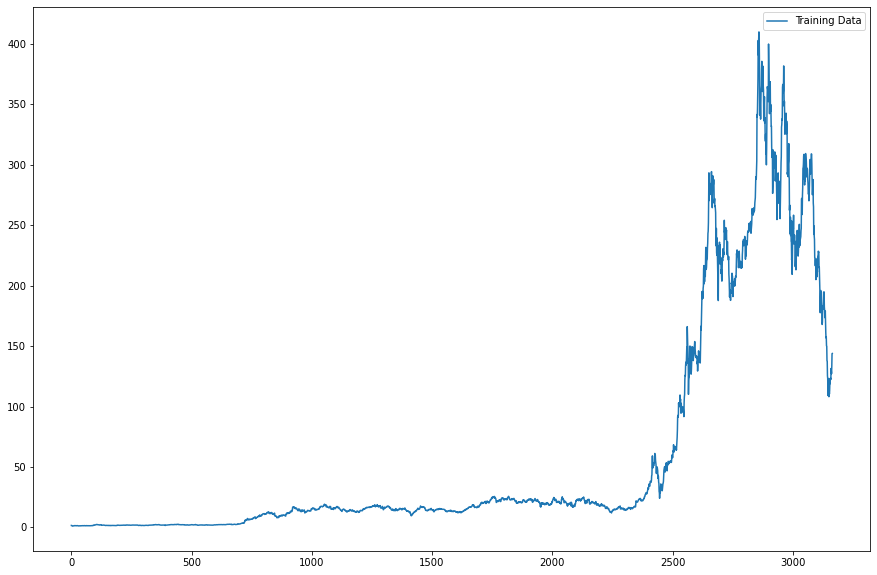

In [131]:
predictions = model_fit.predict(len(data), len(data)+10)
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")